## Attributes classification multi class using CNNs

In [ ]:
# tf imports

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers


import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
print(tf.__version__)

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


In [3]:
import os 
import pandas as pd
import numpy as np
import cv2
import PIL

from PIL import Image
import zipfile

%matplotlib inline
import matplotlib.pyplot as plt 

View sample of images

When transferring files to server, somehow files have been jumbled. Solution is to load from zip instead. This also does not work, just sort the directory instead

In [4]:
# try loading a sample image
image_path = './img_align_celeba.zip'
target_path = './sample_imgs'

def load_images(target_path=target_path,image_path=image_path,N=20, load_all=False):
    """
    unpacks celebA image up till Nth image,
    returns file path where images are stored
    """
    with zipfile.ZipFile(image_path, 'r') as zip_obj:
        fileNameLs = zip_obj.namelist()
        if load_all:
            for filename in fileNameLs: # skip first dir
                zip_obj.extract(filename, target_path)
        else:
            for filename in fileNameLs[1:N+1]: # skip first dir
                zip_obj.extract(filename, target_path)
        print(f"files stored in {target_path}/{fileNameLs[0][:-1]}")

We shall load the images to disk, perform this once only 

In [9]:
# this will overwrite if target path is not changed
# load_images(target_path='./sample_imgs_all', load_all=True)

files stored in ./sample_imgs_all/img_align_celeba


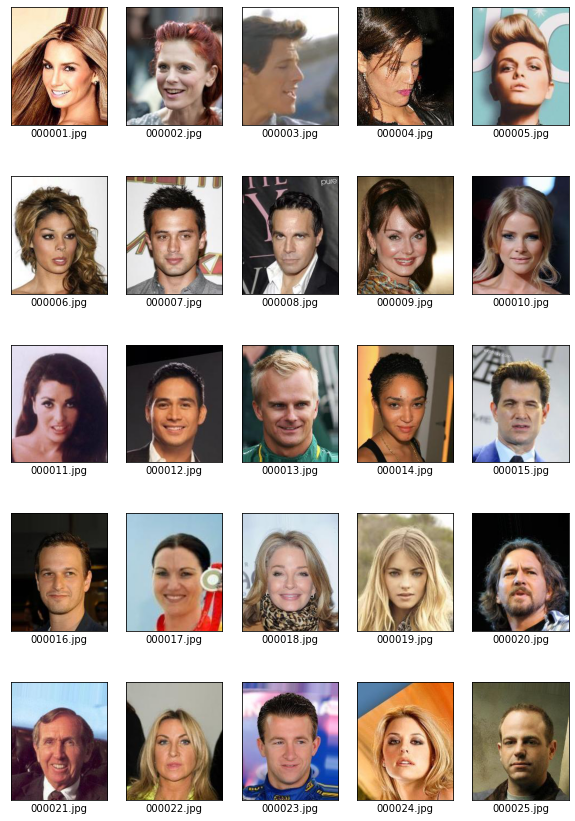

In [5]:
sample_img_dir = './sample_imgs_all/img_align_celeba'
plt.figure(figsize=(10,15))
image_name_ls = os.listdir(sample_img_dir)
image_name_ls.sort(key= lambda x: x.split(',')[0])
for i in range(len(image_name_ls[:25])):
    # lookup by file name instead
    img_path = sample_img_dir+'/'+image_name_ls[i] 
    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5,5,i+1)
    plt.yticks([])
    plt.xticks([])
    plt.xlabel(image_name_ls[i])
    plt.imshow(image_rgb)

plt.show()


Load the facial attributes 

In [6]:
file_path = 'list_attr_celeba.txt'
def load_attr(file_path=file_path, N=10000, load_all=False):
    data = []
    header = ['image_id']
    with open(file_path, 'r') as attribs:
        for i,line in enumerate(attribs):
            if i == 0:
                continue # first row indicates total number of pictures
            if i == 1:
                header+=line.split()
            if load_all:
                if i>1:
                    data.append([0 if x == '-1' else 1 for x in line.split()])
            else:
                if i == N + 2:
                    break
                if i>1 and i <N+2:
                    data.append([0 if x == '-1' else 1 for x in line.split()]) # change to 1-hot            
    return header, data

### Load the attr data

In [7]:
header, face_attr_data = load_attr(load_all=True)
face_attr_df = pd.DataFrame(data=face_attr_data, columns=header)


In [8]:
face_attr_df.shape  # sanity check

(202599, 41)

In [9]:
face_attr_df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,1,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,1,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [10]:
# drop the image_id col

face_attr_df = face_attr_df.drop(columns="image_id")

In [11]:
face_attr_df.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


### Load the train,val,test splits

In [12]:

def load_train_val_test(split_path='list_eval_partition.txt', image_dir=sample_img_dir,
                        image_name_ls=image_name_ls, face_attr_df=face_attr_df, subset=0.3):
    """
    loads the image data as a np.array, then normalise the data
    splits the data into train,val,test
    design matrix is a numpy array, the outcome matrix is a pandas dataframe
    subset is between 0 and 1, if 0 no data is loaded, if 1 then all the data is loaded each set
    
    """
    # load all images into np_array
    all_images_arr = np.array([np.asarray(Image.open(image_dir+'/'+ image_name_ls[i])) 
                               for i in range(len(image_name_ls))])
    # load the splits
    split_data = []
    with open(split_path, 'r') as in_file:
        for line in in_file:
            split_data.append(int(line.split()[1]))
    split_arr = np.array(split_data)
    
    # get the subsets for train, val, test
    train_subset = int(len(split_arr[split_arr==0])*subset) 
    val_subset = int(len(split_arr[split_arr==1])*subset)
    test_subset = int(len(split_arr[split_arr==2])*subset)

    X_train = all_images_arr[split_arr==0][:train_subset]/255.
    X_val = all_images_arr[split_arr==1][:val_subset]/255.
    X_test = all_images_arr[split_arr==2][:test_subset]/255.
    
    y_train = face_attr_df.iloc[split_arr==0][:train_subset]
    y_val = face_attr_df.iloc[split_arr==1][:val_subset]
    y_test = face_attr_df.iloc[split_arr==2][:test_subset]
    
    
    return X_train, X_val, X_test, y_train, y_val, y_test
        
        

### Load the splits

In [13]:
%%time
# run once 

X_train, X_val, X_test, y_train, y_val, y_test = load_train_val_test()

CPU times: user 1min 42s, sys: 17.5 s, total: 1min 59s
Wall time: 2min 3s


In [14]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(48831, 218, 178, 3) (5960, 218, 178, 3) (5988, 218, 178, 3)
(48831, 40) (5960, 40) (5988, 40)


### Create custom avg acc metric

In [97]:
# create custom metrics via prob threshold function
def one_hot(x, threshold=0.5):
    """
    func for apply_along_axis
    for this case x is a 1-D array
    """
    x[x>=threshold] = 1
    x[x<threshold] = 0
    return x

def avg_accuracy(y_true, y_pred):
    """
    to return the avg accuracy of all attributes
    y_true: np array of one hot, shape is (,40)
    y_pred: np array of sigmoid activations, 0<1, shape is (,40)
    """
    y_pred_arr = y_pred.numpy()
    y_pred_cp = y_pred_arr.copy()
    
#     tf.convert_to_tensor()
    
    # change accuracy to one-hot with threshold prob at 0.5
    np.apply_along_axis(one_hot, 0, y_pred_cp, threshold=0.5) # change in place 
    
    # Get the accuracy per label
    y_true_arr = y_true.numpy()
    acc_res = y_pred_cp==y_true_arr
#     print(acc_res.shape)
#     print(acc_res)
#     raise AssertionError()
    acc_res_final = acc_res.sum(axis=0)/acc_res.shape[0]
#     print(acc_res_final)
    mean_acc = acc_res_final.sum()/len(acc_res_final)    
    
    return round(mean_acc, 2)
# """
# (32, 40)
# [[False  True  True ...  True  True  True]
#  [ True  True False ... False  True  True]
#  [ True  True False ...  True  True  True]
#  ...
#  [ True  True  True ...  True  True  True]
#  [ True  True False ...  True  True  True]
#  [ True  True  True ...  True  True  True]]
# 31.46875
# """

# def avg_accuracy(y_true, y_pred):
#     """
#     ytrue and ypred are tensors
#     """
    
#     a = tf.Tensor()
    

### Load resnet 50

In [56]:
resnet = tf.keras.applications.ResNet50(include_top=False,
                                       weights=None,)

In [98]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       multiple             0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             multiple             9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   multiple             256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### Create baseline model 

In [99]:
def load_model(base_model=resnet):
    
    x = base_model(inputs, training=False)
    x = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(40, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    
    return model
    

In [100]:
model = load_model()

In [101]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 218, 178, 3)]     0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 86016)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 40)                3440680   
Total params: 27,028,392
Trainable params: 26,975,272
Non-trainable params: 53,120
_________________________________________________________________


### Compile model 

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=[avg_accuracy],
              run_eagerly=True)

### Set model callbacks

In [104]:
callback_ls = [
               keras.callbacks.CSVLogger('training-log-5.csv', append=True,),
               keras.callbacks.ModelCheckpoint(filepath='ml_clf_6.tf',
                                               monitor='val_avg_accuracy',mode='max',
                                               save_weights_only=False,
                                               save_best_only=True), # need to change the accuracy
              ]

### Fit model 

In [70]:
%%time
epochs = 2
batch_size = 64

history = model.fit(X_train,y_train,epochs=epochs,
                    validation_data=(X_val,y_val),
                    batch_size=batch_size,
                    callbacks=callback_ls)

Epoch 1/2
763/763 [==============================] - 207s 271ms/step - loss: 0.3585 - accuracy: 0.0107 - avg_accuracy: 0.8424 - val_loss: 0.2912 - val_accuracy: 0.0186 - val_avg_accuracy: 0.8733
Epoch 2/2
763/763 [==============================] - 208s 272ms/step - loss: 0.2717 - accuracy: 0.0177 - avg_accuracy: 0.8809 - val_loss: 0.2568 - val_accuracy: 0.0161 - val_avg_accuracy: 0.8880
CPU times: user 4min 48s, sys: 23.6 s, total: 5min 12s
Wall time: 7min 10s


In [106]:
%%time
epochs = 15
batch_size = 64

history = model.fit(X_train,y_train,epochs=epochs,
                    validation_data=(X_val,y_val),
                    batch_size=batch_size,
                    callbacks=callback_ls)

Epoch 1/15
763/763 [==============================] - 223s 292ms/step - loss: 0.2629 - accuracy: 0.0175 - avg_accuracy: 0.8849 - val_loss: 0.2552 - val_accuracy: 0.0188 - val_avg_accuracy: 0.8885
Epoch 2/15
763/763 [==============================] - 226s 296ms/step - loss: 0.2372 - accuracy: 0.0199 - avg_accuracy: 0.8953 - val_loss: 0.2426 - val_accuracy: 0.0168 - val_avg_accuracy: 0.8933
Epoch 3/15
763/763 [==============================] - 225s 295ms/step - loss: 0.2239 - accuracy: 0.0200 - avg_accuracy: 0.9016 - val_loss: 0.2410 - val_accuracy: 0.0178 - val_avg_accuracy: 0.8946
Epoch 4/15
763/763 [==============================] - 208s 273ms/step - loss: 0.2106 - accuracy: 0.0212 - avg_accuracy: 0.9073 - val_loss: 0.2424 - val_accuracy: 0.0196 - val_avg_accuracy: 0.8941
Epoch 5/15
763/763 [==============================] - 208s 273ms/step - loss: 0.1965 - accuracy: 0.0218 - avg_accuracy: 0.9140 - val_loss: 0.2516 - val_accuracy: 0.0200 - val_avg_accuracy: 0.8911
Epoch 6/15
763/763 [

### Visualize training curves

In [129]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'avg_accuracy', 'val_loss', 'val_accuracy', 'val_avg_accuracy'])

In [132]:
def plot_training_curves(history):
    acc = history.history['avg_accuracy']
    val_acc = history.history['val_avg_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(15)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

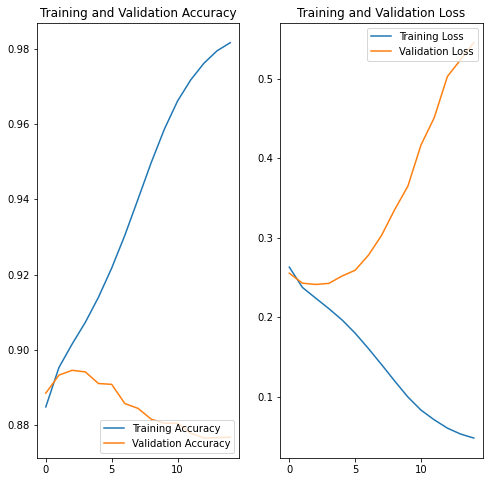

In [133]:
plot_training_curves(history)

### Evaluate test accuracy

In [169]:
# load best model 
load_model2 = keras.models.load_model('ml_clf_6.tf/', 
                                      custom_objects={'avg_accuracy':avg_accuracy})

In [184]:
y_pred = load_model2.predict(X_test)

In [185]:
# change accuracy to one-hot with threshold prob at 0.5
np.apply_along_axis(one_hot, 0, y_pred) # change in place 

# Get the accuracy per label

acc_res = y_pred==y_test

acc_res_final = acc_res.sum()/len(acc_res)

In [186]:
acc_res_final.mean()

0.8907773881095524

In [188]:
print("test avg accuracy: ",round(acc_res_final.mean(),2))

test avg accuracy:  0.89


### Plot accuracy per class

In [203]:
import seaborn as sns
sns.set_style(style='darkgrid')

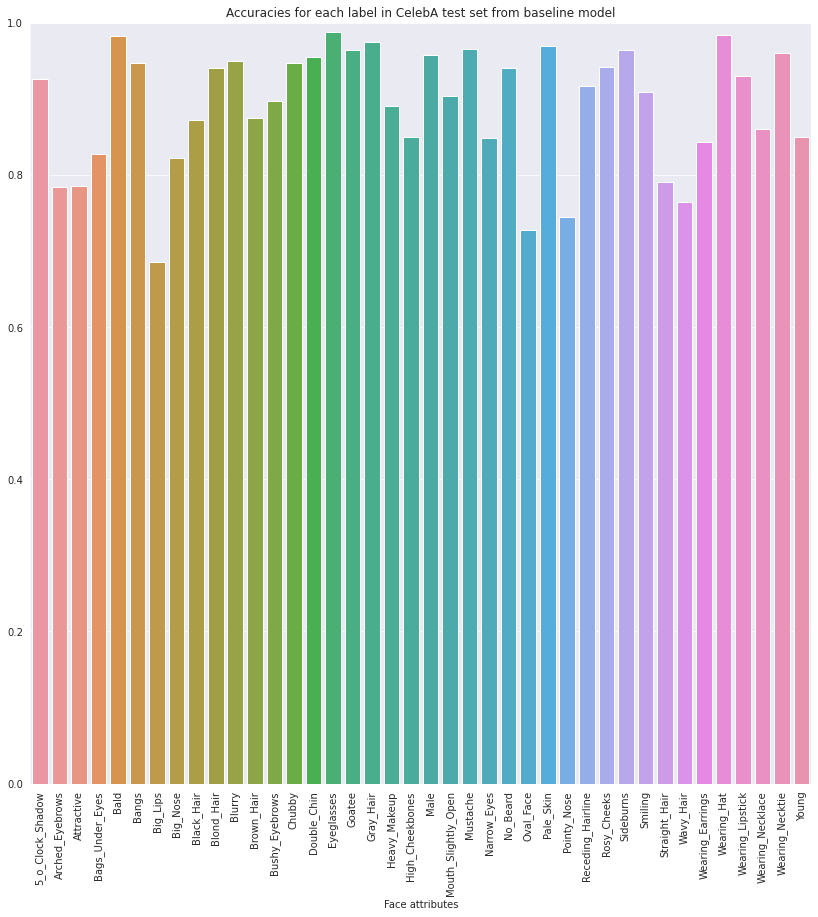

In [205]:
plt.figure(figsize=(14,14))
sns.barplot(x=acc_res_final.index,y=acc_res_final)
plt.xticks(rotation=90)
plt.xlabel('Face attributes')
plt.title("Accuracies for each label in CelebA test set from baseline model")
plt.ylim((0,1))
# plt.axhline(y=0.7)
plt.savefig('accuracy_plt_baseline.png', dpi=150)
plt.show()


## Second model with lower learning rates

In [154]:
model1 = load_model()

In [155]:
model1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 218, 178, 3)]     0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
flatten_6 (Flatten)          (None, 86016)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 40)                3440680   
Total params: 27,028,392
Trainable params: 26,975,272
Non-trainable params: 53,120
_________________________________________________________________


### Compile model 

In [189]:
model1.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001),
               loss='binary_crossentropy', 
               metrics=[avg_accuracy],
               run_eagerly=True)

### Set model callbacks

In [191]:
callback_ls = [
#                keras.callbacks.CSVLogger('training-log-6.csv', append=True,),
               keras.callbacks.ModelCheckpoint(filepath='ml_clf_7.tf',
                                               monitor='val_avg_accuracy',
                                               mode='max',
                                               save_best_only=True), # need to change the accuracy
              ]

### Fit model 

In [192]:
%%time
epochs = 15
batch_size = 64

history1 = model1.fit(X_train,y_train,epochs=epochs,
                    validation_data=(X_val,y_val),
                    batch_size=batch_size,
                    callbacks=callback_ls)

Epoch 1/15
763/763 [==============================] - 213s 279ms/step - loss: 0.0262 - avg_accuracy: 0.9904 - val_loss: 0.5478 - val_avg_accuracy: 0.8815
Epoch 2/15
763/763 [==============================] - 213s 279ms/step - loss: 0.0048 - avg_accuracy: 1.0000 - val_loss: 0.7500 - val_avg_accuracy: 0.8832
Epoch 3/15
763/763 [==============================] - 196s 257ms/step - loss: 0.0021 - avg_accuracy: 1.0000 - val_loss: 0.8406 - val_avg_accuracy: 0.8821
Epoch 4/15
763/763 [==============================] - 199s 261ms/step - loss: 0.0021 - avg_accuracy: 1.0000 - val_loss: 0.8959 - val_avg_accuracy: 0.8824
Epoch 5/15
763/763 [==============================] - 197s 258ms/step - loss: 0.0056 - avg_accuracy: 0.9999 - val_loss: 0.8796 - val_avg_accuracy: 0.8819
Epoch 6/15
763/763 [==============================] - 195s 256ms/step - loss: 0.0057 - avg_accuracy: 1.0000 - val_loss: 0.9078 - val_avg_accuracy: 0.8813
Epoch 7/15
763/763 [==============================] - 196s 257ms/step - loss

### Evaluate model 

In [193]:
load_model3 = keras.models.load_model('ml_clf_7.tf/', 
                                     custom_objects={'avg_accuracy':avg_accuracy})

In [198]:
y_pred = load_model3.predict(X_test)

In [199]:
# change accuracy to one-hot with threshold prob at 0.5
np.apply_along_axis(one_hot, 0, y_pred) # change in place 

# Get the accuracy per label

acc_res1 = y_pred==y_test

acc_res_final_1 = acc_res1.sum()/len(acc_res1)

In [200]:
acc_res_final_1.mean()

0.8790288911155644

In [201]:
print("test avg accuracy: ",round(acc_res_final_1.mean(),2))

test avg accuracy:  0.88


### Plot accuracy per class

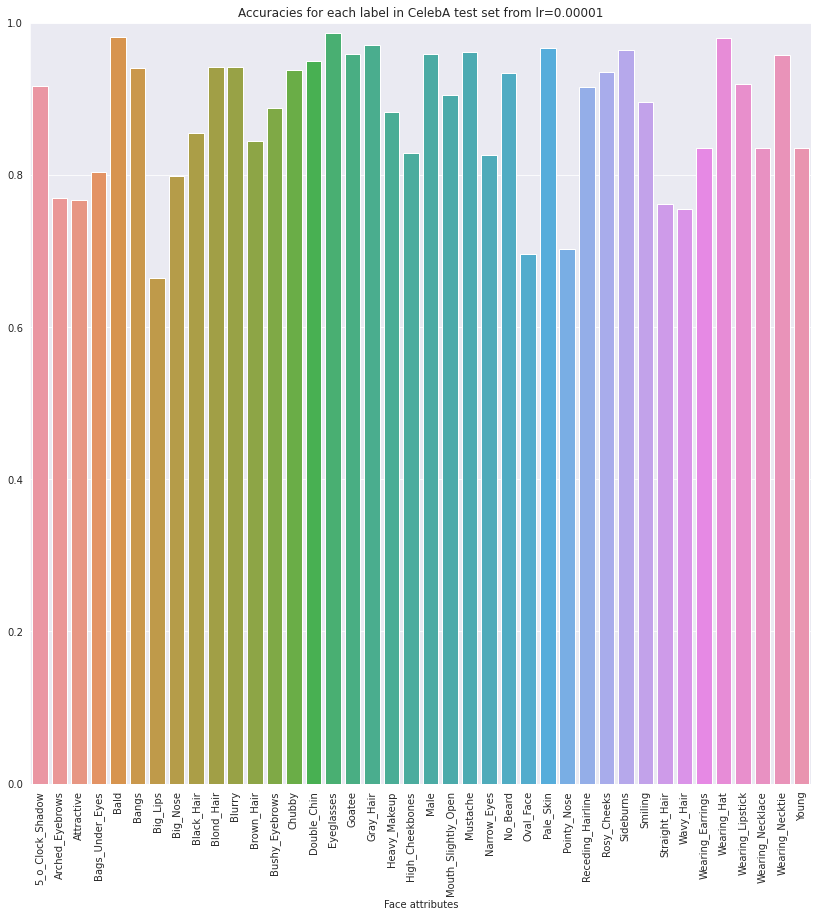

In [207]:
plt.figure(figsize=(14,14))
sns.barplot(x=acc_res_final_1.index,y=acc_res_final_1)
plt.xticks(rotation=90)
plt.xlabel('Face attributes')
plt.title("Accuracies for each label in CelebA test set from lr=0.00001")
plt.ylim((0,1))
plt.savefig('accuracy_plt_second_model.png', dpi=150)
plt.show()

## Appendix